<a href="https://colab.research.google.com/github/damianodea/hpc_2025/blob/main/UNet_for_Image_segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Image segmentation with a U-Net-like architecture

This notebook presents an example of image segmentation task performed using a **U-Net** model trained from scratch on the **Oxford Pets dataset**.

**Full tutorial**: [keras tutorial](https://keras.io/examples/vision/oxford_pets_image_segmentation/)

**Credits:** [fchollet](https://twitter.com/fchollet)<br>

## The Oxford-IIIT Pet Dataset

# Oxford-IIIT Pet Dataset

The Oxford-IIIT Pet Dataset is a comprehensive collection of *7,349 images* featuring *37 different pet categories* (25 dog breeds and 12 cat breeds).

What makes this dataset particularly valuable for image segmentation tasks is that it provides pixel-level trimap segmentation labels that distinguish between:

- foreground (pet),
- background,
- boundary/unclear regions

The images present varying scales, poses, and lighting conditions, capturing pets in natural environments.

This rich annotation combined with significant intra-class variations in color, breed markings, and fur textures makes it an excellent benchmark for evaluating segmentation algorithms, particularly those focused on delineating complex object boundaries in real-world scenarios.

The dataset is available at [link](https://www.robots.ox.ac.uk/~vgg/data/pets/)

In [ ]:
!wget https://thor.robots.ox.ac.uk/~vgg/data/pets/images.tar.gz
!wget https://thor.robots.ox.ac.uk/~vgg/data/pets/annotations.tar.gz

!tar -xzf images.tar.gz
!tar -xf annotations.tar.gz

--2025-03-17 09:45:56--  https://thor.robots.ox.ac.uk/~vgg/data/pets/images.tar.gz
Resolving thor.robots.ox.ac.uk (thor.robots.ox.ac.uk)... 129.67.95.98
Connecting to thor.robots.ox.ac.uk (thor.robots.ox.ac.uk)|129.67.95.98|:443... connected.
HTTP request sent, awaiting response... 308 Permanent Redirect
Location: https://thor.robots.ox.ac.uk/pets/images.tar.gz [following]
--2025-03-17 09:45:57--  https://thor.robots.ox.ac.uk/pets/images.tar.gz
Reusing existing connection to thor.robots.ox.ac.uk:443.
HTTP request sent, awaiting response... 200 OK
Length: 791918971 (755M) [application/octet-stream]
Saving to: ‘images.tar.gz’

images.tar.gz       100%[===================>] 755.23M  20.1MB/s    in 38s     

2025-03-17 09:46:36 (19.7 MB/s) - ‘images.tar.gz’ saved [791918971/791918971]

--2025-03-17 09:46:36--  https://thor.robots.ox.ac.uk/~vgg/data/pets/annotations.tar.gz
Resolving thor.robots.ox.ac.uk (thor.robots.ox.ac.uk)... 129.67.95.98
Connecting to thor.robots.ox.ac.uk (thor.robots.o

## Prepare paths of input images and target segmentation masks

In [ ]:
import os

input_dir = "images/"
target_dir = "annotations/trimaps/"
img_size = (160, 160)
num_classes = 3
batch_size = 32

input_img_paths = sorted(
    [
        os.path.join(input_dir, fname)
        for fname in os.listdir(input_dir)
        if fname.endswith(".jpg")
    ]
)
target_img_paths = sorted(
    [
        os.path.join(target_dir, fname)
        for fname in os.listdir(target_dir)
        if fname.endswith(".png") and not fname.startswith(".")
    ]
)

print("Number of samples:", len(input_img_paths))

for input_path, target_path in zip(input_img_paths[:10], target_img_paths[:10]):
    print(input_path, "|", target_path)

Number of samples: 7390
images/Abyssinian_1.jpg | annotations/trimaps/Abyssinian_1.png
images/Abyssinian_10.jpg | annotations/trimaps/Abyssinian_10.png
images/Abyssinian_100.jpg | annotations/trimaps/Abyssinian_100.png
images/Abyssinian_101.jpg | annotations/trimaps/Abyssinian_101.png
images/Abyssinian_102.jpg | annotations/trimaps/Abyssinian_102.png
images/Abyssinian_103.jpg | annotations/trimaps/Abyssinian_103.png
images/Abyssinian_104.jpg | annotations/trimaps/Abyssinian_104.png
images/Abyssinian_105.jpg | annotations/trimaps/Abyssinian_105.png
images/Abyssinian_106.jpg | annotations/trimaps/Abyssinian_106.png
images/Abyssinian_107.jpg | annotations/trimaps/Abyssinian_107.png


## Data visualization

Let's inspect how input images and corresponding segmentation masks look like.

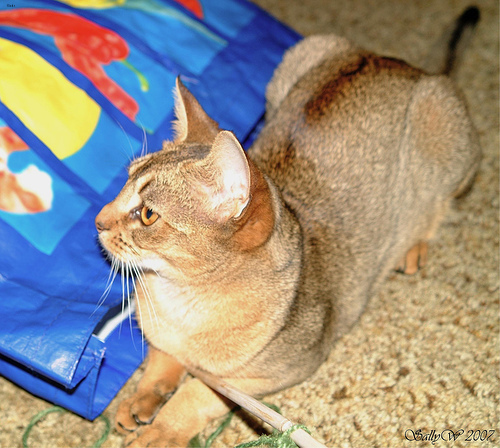

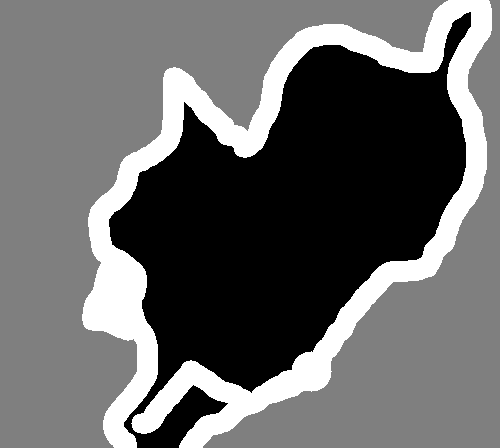

In [ ]:
from IPython.display import Image, display
from keras.utils import load_img
from PIL import ImageOps

# Display input image #7
display(Image(filename=input_img_paths[9]))

# Display auto-contrast version of corresponding target (per-pixel categories)
img = ImageOps.autocontrast(load_img(target_img_paths[9]))
display(img)

## Data preparation

As first step before training we need to prepare data to be feed into a model.

This includes:

 - loading images and corresponding masks in pairs
 - ensure they are conveniently vectorized and batched
 - this ensures efficient feeding into the network

 For the latter step we will use a dataloader in the form of a `tensorflow.data.Dataset`. This is a built-in TensorFlow util that helps efficiently loading data from disk, store it in memory and feeding to the network.

In [ ]:
import keras
import numpy as np
from tensorflow import data as tf_data
from tensorflow import image as tf_image
from tensorflow import io as tf_io


def get_dataset(
    batch_size,
    img_size,
    input_img_paths,
    target_img_paths,
    max_dataset_len=None,
):
    """Returns a TF Dataset."""

    def load_img_masks(input_img_path, target_img_path):
        input_img = tf_io.read_file(input_img_path)
        input_img = tf_io.decode_png(input_img, channels=3)
        input_img = tf_image.resize(input_img, img_size)
        input_img = tf_image.convert_image_dtype(input_img, "float32")

        target_img = tf_io.read_file(target_img_path)
        target_img = tf_io.decode_png(target_img, channels=1)
        target_img = tf_image.resize(target_img, img_size, method="nearest")
        target_img = tf_image.convert_image_dtype(target_img, "uint8")

        # Ground truth labels are 1, 2, 3. Subtract one to make them 0, 1, 2:
        target_img -= 1
        return input_img, target_img

    # For faster debugging, limit the size of data
    if max_dataset_len:
        input_img_paths = input_img_paths[:max_dataset_len]
        target_img_paths = target_img_paths[:max_dataset_len]
    dataset = tf_data.Dataset.from_tensor_slices((input_img_paths, target_img_paths))
    dataset = dataset.map(load_img_masks, num_parallel_calls=tf_data.AUTOTUNE)
    return dataset.batch(batch_size)

images.shape=TensorShape([3, 160, 160, 3])
masks.shape=TensorShape([3, 160, 160, 1])


<ipython-input-77-09fe38ad4405>:31: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap('viridis', 3)
<ipython-input-77-09fe38ad4405>:48: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


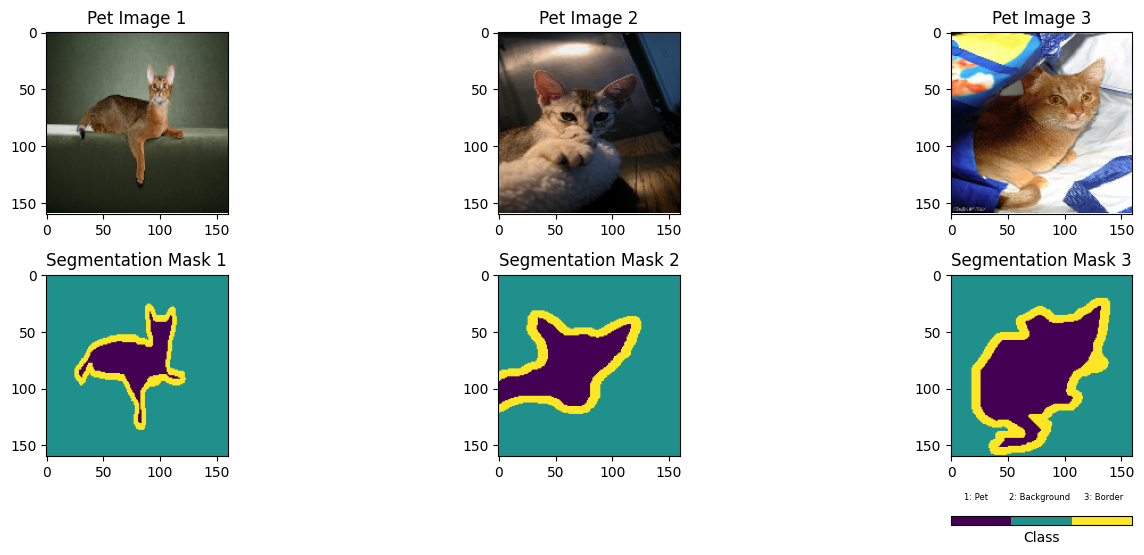

Demonstrating dataset iteration:
Batch 1:
  Image batch shape: (3, 160, 160, 3)
  Mask batch shape: (3, 160, 160, 1)
  Image value range: 0.0 to 255.0
  Mask classes: [0 1 2]

Batch 2:
  Image batch shape: (3, 160, 160, 3)
  Mask batch shape: (3, 160, 160, 1)
  Image value range: 0.0 to 255.0
  Mask classes: [0 1 2]



In [ ]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes


# Create a small sample for demonstration
sample_dataset = get_dataset(
    batch_size=3,
    img_size=(160, 160),
    input_img_paths=input_img_paths,
    target_img_paths=target_img_paths,
    max_dataset_len=15  # Just use a few images for demonstration
)

# Function to visualize the dataset
def visualize_batch(batch, n_images=3):
    images, masks = batch

    fig, axes = plt.subplots(2, n_images, figsize=(15, 5))
    for i in range(min(n_images, len(images))):
        # Display original image
        # plt.subplot(2, n_images, i + 1)
        axes[0, i].imshow(images[i].numpy().astype(np.uint8) / 255)
        axes[0, i].set_title(f"Pet Image {i+1}")
        # plt.set_axis("off")

        # Display segmentation mask (convert to color for visibility)
        # plt.subplot(2, n_images, i + n_images + 1)
        # Add 1 back to get original labels (1, 2, 3)
        mask_display = masks[i] + 1
        # Create a colormap: 1=pet, 2=background, 3=border
        cmap = plt.cm.get_cmap('viridis', 3)
        axes[1, i].imshow(mask_display[:,:,0], cmap=cmap, vmin=1, vmax=3)
        axes[1, i].set_title(f"Segmentation Mask {i+1}")
        # # axes[1, i].set_axis("off")

    axins = inset_axes(axes[1, i],
                    width="100%",
                    height="5%",
                    loc='lower center',
                    borderpad=-5
                   )
    plt.colorbar(plt.cm.ScalarMappable(cmap=cmap), cax=axins, ax=plt.gcf().get_axes(),
                label='Class', ticks=[3.33, 4, 4.67],
                orientation='horizontal')
    plt.figtext(0.75, -0.01, "1: Pet", fontsize=6)
    plt.figtext(0.78, -0.01, "2: Background", fontsize=6)
    plt.figtext(0.83, -0.01, "3: Border", fontsize=6)
    plt.tight_layout()
    plt.show()

# Get a batch and visualize it
for images, masks in sample_dataset.take(1):
    print(f"{images.shape=}")
    print(f"{masks.shape=}")
    visualize_batch((images, masks))
    break

# Demonstrate how to iterate through the dataset
print("Demonstrating dataset iteration:")
for i, (images, masks) in enumerate(sample_dataset.take(2)):
    print(f"Batch {i+1}:")
    print(f"  Image batch shape: {images.shape}")
    print(f"  Mask batch shape: {masks.shape}")
    print(f"  Image value range: {np.min(images.numpy())} to {np.max(images.numpy())}")
    print(f"  Mask classes: {np.unique(masks.numpy())}")
    print()

This model implements a modern variant of the U-Net architecture, enhanced with Xception-inspired design elements for efficient image segmentation. The architecture follows the classic encoder-decoder pattern with several key features:

- Encoder Path (Downsampling): the first half progressively reduces spatial dimensions while increasing feature depth. It uses separable convolutions (from Xception) which are more parameter-efficient than standard convolutions while maintaining representational power.
- Decoder Path (Upsampling): the second half gradually recovers spatial information while decreasing feature depth, using transposed convolutions and upsampling operations.
- Skip Connections: these critical connections link corresponding layers between the encoder and decoder paths, allowing spatial details lost during downsampling to flow directly to the decoder for more precise segmentation boundaries.
- Residual Connections: inspired by ResNet, these connections help with gradient flow during training by providing alternate pathways through the network, making it easier to train deeper models.
- Bottleneck: the middle section between encoder and decoder creates a compressed representation of input features, capturing essential semantic information.

The final layer uses a softmax activation to produce per-pixel class probabilities across our three classes (pet, background, and boundary). This architecture is particularly well-suited for the Oxford Pet dataset as it can effectively learn to distinguish between fine pet features (like fur patterns and outlines) while maintaining computational efficiency.

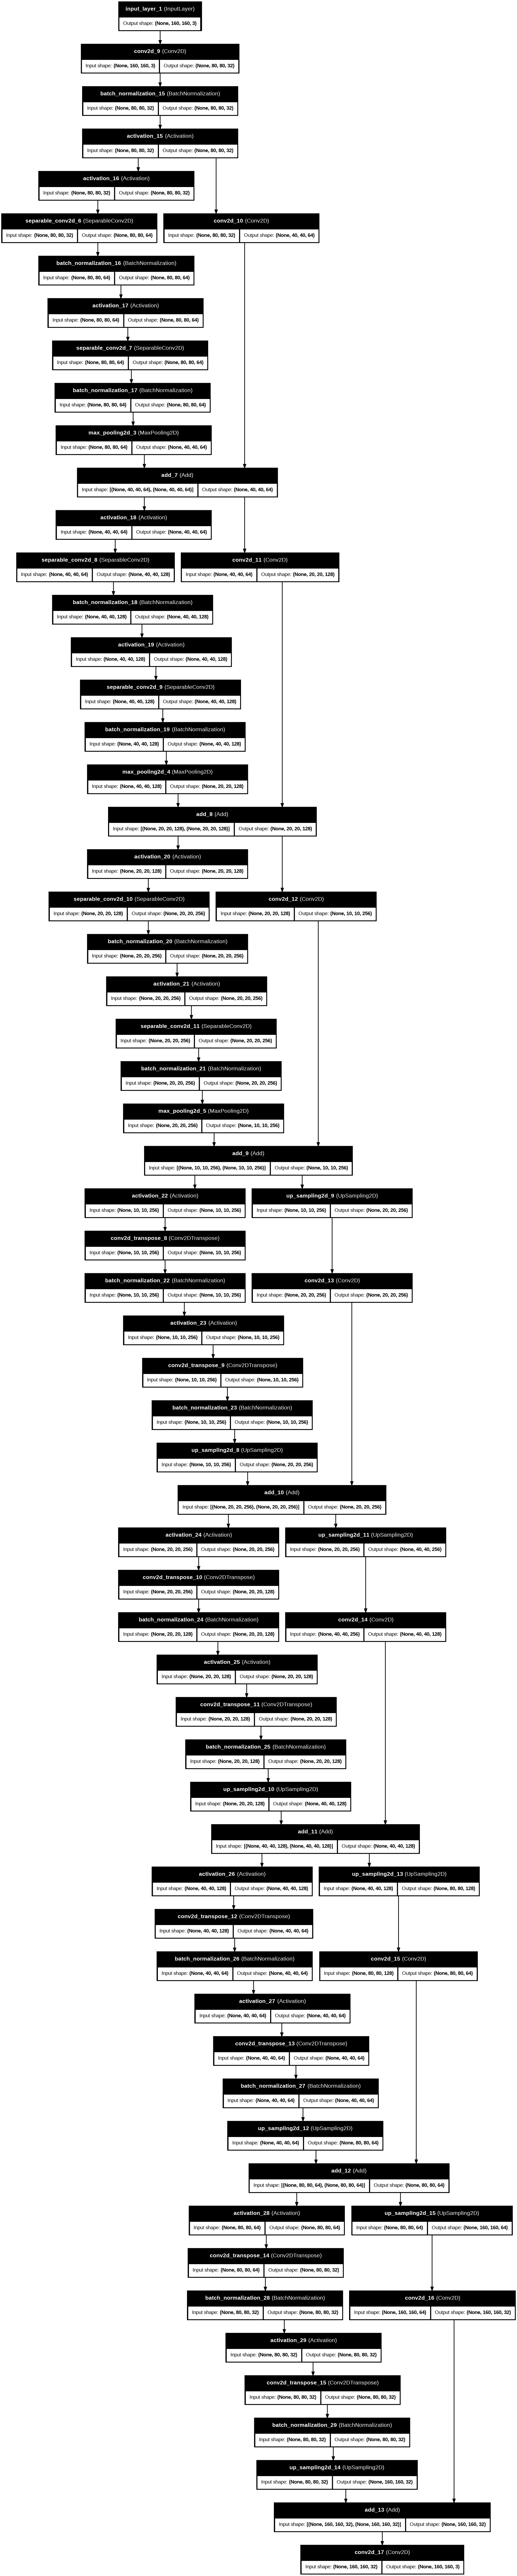

In [ ]:
from keras import layers
from keras.utils import plot_model

def get_model(img_size, num_classes):
    inputs = keras.Input(shape=img_size + (3,))

    ### [First half of the network: downsampling inputs] ###

    # Entry block
    x = layers.Conv2D(32, 3, strides=2, padding="same")(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    previous_block_activation = x  # Set aside residual

    # Blocks 1, 2, 3 are identical apart from the feature depth.
    for filters in [64, 128, 256]:
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

        # Project residual
        residual = layers.Conv2D(filters, 1, strides=2, padding="same")(
            previous_block_activation
        )
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    ### [Second half of the network: upsampling inputs] ###

    for filters in [256, 128, 64, 32]:
        x = layers.Activation("relu")(x)
        x = layers.Conv2DTranspose(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.Conv2DTranspose(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.UpSampling2D(2)(x)

        # Project residual
        residual = layers.UpSampling2D(2)(previous_block_activation)
        residual = layers.Conv2D(filters, 1, padding="same")(residual)
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    # Add a per-pixel classification layer
    outputs = layers.Conv2D(num_classes, 3, activation="softmax", padding="same")(x)

    # Define the model
    model = keras.Model(inputs, outputs)
    return model


# Build model
model = get_model(img_size, num_classes)
model.summary()

# Plot model architecture and save as image
# plot_model(
#     model,
#     to_file='unet_xception_architecture.png',
#     show_shapes=True,
#     show_dtype=False,
#     show_layer_names=True,
#     rankdir='TB',  # Top to bottom layout
#     expand_nested=False,
#     dpi=96
# )

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2             │ (None, 160, 160, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_18 (Conv2D)        │ (None, 80, 80, 32)     │            896 │ input_layer_2[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_30    │ (None, 80, 80, 32)     │            128 │ conv2d_18[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_30             │ (None, 80, 80, 32)     │              0 │ batch_normalization_3… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_31             │ (None, 80, 80, 32)     │              0 │ activation_30[0][0]    │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ separable_conv2d_12       │ (None, 80, 80, 64)     │          2,400 │ activation_31[0][0]    │
│ (SeparableConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_31    │ (None, 80, 80, 64)     │            256 │ separable_conv2d_12[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_32             │ (None, 80, 80, 64)     │              0 │ batch_normalization_3… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ separable_conv2d_13       │ (None, 80, 80, 64)     │          4,736 │ activation_32[0][0]    │
│ (SeparableConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_32    │ (None, 80, 80, 64)     │            256 │ separable_conv2d_13[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_6           │ (None, 40, 40, 64)     │              0 │ batch_normalization_3… │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_19 (Conv2D)        │ (None, 40, 40, 64)     │          2,112 │ activation_30[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_14 (Add)              │ (None, 40, 40, 64)     │              0 │ max_pooling2d_6[0][0], │
│                           │                        │                │ conv2d_19[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_33             │ (None, 40, 40, 64)     │              0 │ add_14[0][0]           │
│ (Activation)         

 Total params: 2,058,979 (7.85 MB)

 Trainable params: 2,055,203 (7.84 MB)

 Non-trainable params: 3,776 (14.75 KB)

## Set aside a validation split

In [ ]:
import random

# Split our img paths into a training and a validation set
val_samples = 1000
random.Random(1337).shuffle(input_img_paths)
random.Random(1337).shuffle(target_img_paths)
train_input_img_paths = input_img_paths[:-val_samples]
train_target_img_paths = target_img_paths[:-val_samples]
val_input_img_paths = input_img_paths[-val_samples:]
val_target_img_paths = target_img_paths[-val_samples:]

# Instantiate dataset for each split
# Limit input files in `max_dataset_len` for faster epoch training time.
# Remove the `max_dataset_len` arg when running with full dataset.
train_dataset = get_dataset(
    batch_size,
    img_size,
    train_input_img_paths,
    train_target_img_paths,
    max_dataset_len=1000,
)
valid_dataset = get_dataset(
    batch_size, img_size, val_input_img_paths, val_target_img_paths
)

## Train the model

In [ ]:
# Configure the model for training.
# We use the "sparse" version of categorical_crossentropy
# because our target data is integers.
model.compile(
    optimizer=keras.optimizers.Adam(1e-4), loss="sparse_categorical_crossentropy"
)

callbacks = [
    keras.callbacks.ModelCheckpoint("oxford_segmentation.keras", save_best_only=True)
]

# Train the model, doing validation at the end of each epoch.
epochs = 50
model.fit(
    train_dataset,
    epochs=epochs,
    validation_data=valid_dataset,
    callbacks=callbacks,
    verbose=2,
)

In [ ]:
import tensorflow as tf
from tensorflow import keras
import numpy as np

# Define IoU metric
def iou(y_true, y_pred, smooth=1e-6):
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred > 0.5, tf.float32)  # Convert predictions to binary
    intersection = tf.reduce_sum(y_true * y_pred)
    union = tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) - intersection
    return (intersection + smooth) / (union + smooth)

# Define Dice Coefficient metric
def dice_coefficient(y_true, y_pred, smooth=1e-6):
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred > 0.5, tf.float32)  # Convert predictions to binary
    intersection = tf.reduce_sum(y_true * y_pred)
    return (2. * intersection + smooth) / (tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) + smooth)

# Compile the model with the new metrics
model.compile(
    optimizer=keras.optimizers.Adam(1e-4),
    loss="sparse_categorical_crossentropy",
    metrics=[iou, dice_coefficient]
)

# Define callbacks
callbacks = [
    keras.callbacks.ModelCheckpoint("oxford_segmentation.keras", save_best_only=True)
]

# Train the model
epochs = 50
model.fit(
    train_dataset,
    epochs=epochs,
    validation_data=valid_dataset,
    callbacks=callbacks,
    verbose=2,
)

Epoch 1/50
32/32 - 48s - 1s/step - dice_coefficient: 0.8890 - iou: 0.8005 - loss: 1.3958 - val_dice_coefficient: 0.8472 - val_iou: 0.7352 - val_loss: 1.2785
Epoch 2/50
32/32 - 8s - 240ms/step - dice_coefficient: 0.8761 - iou: 0.7797 - loss: 0.8527 - val_dice_coefficient: 0.8868 - val_iou: 0.7968 - val_loss: 1.1381
Epoch 3/50
32/32 - 9s - 278ms/step - dice_coefficient: 0.8700 - iou: 0.7701 - loss: 0.7390 - val_dice_coefficient: 0.8952 - val_iou: 0.8105 - val_loss: 1.4635
Epoch 4/50
32/32 - 10s - 318ms/step - dice_coefficient: 0.8666 - iou: 0.7648 - loss: 0.6783 - val_dice_coefficient: 0.8968 - val_iou: 0.8132 - val_loss: 2.0294
Epoch 5/50
32/32 - 10s - 319ms/step - dice_coefficient: 0.8644 - iou: 0.7615 - loss: 0.6343 - val_dice_coefficient: 0.8979 - val_iou: 0.8150 - val_loss: 2.6553
Epoch 6/50
32/32 - 10s - 327ms/step - dice_coefficient: 0.8632 - iou: 0.7596 - loss: 0.5983 - val_dice_coefficient: 0.8984 - val_iou: 0.8158 - val_loss: 3.2658
Epoch 7/50
32/32 - 9s - 276ms/step - dice_coe

## Visualize predictions

32/32 ━━━━━━━━━━━━━━━━━━━━ 8s 151ms/step


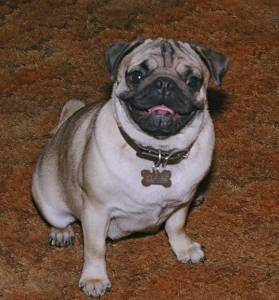

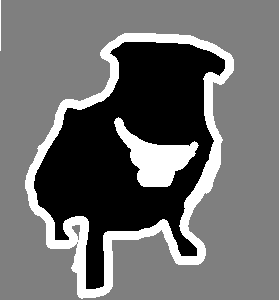

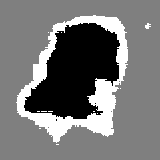

In [ ]:
# Generate predictions for all images in the validation set

val_dataset = get_dataset(
    batch_size, img_size, val_input_img_paths, val_target_img_paths
)
val_preds = model.predict(val_dataset)


def display_mask(i):
    """Quick utility to display a model's prediction."""
    mask = np.argmax(val_preds[i], axis=-1)
    mask = np.expand_dims(mask, axis=-1)
    img = ImageOps.autocontrast(keras.utils.array_to_img(mask))
    display(img)


# Display results for validation image #10
i = 10

# Display input image
display(Image(filename=val_input_img_paths[i]))

# Display ground-truth target mask
img = ImageOps.autocontrast(load_img(val_target_img_paths[i]))
display(img)

# Display mask predicted by our model
display_mask(i)  # Note that the model only sees inputs at 150x150.

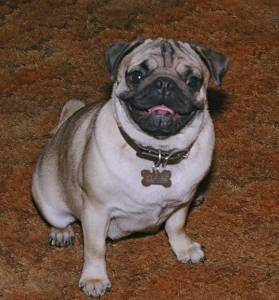


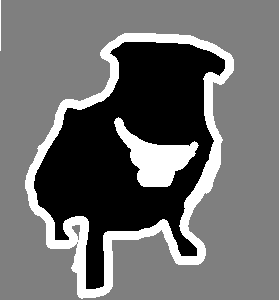

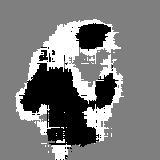